# Objective :

* **Find turns using "Position-Based Turn Detection"**
* **Find turning speeds**

Based upon the following research paper (chapter 4) : https://ir.lib.uwo.ca/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=6640&context=etd

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [193]:
df = pd.read_csv("datasets/company_raw.csv")

## Exploratory data analysis and some cleaning

In [194]:
df.head()

,Unnamed: 0,heading,id,img_front,lat,lon,speed,timestamp
0,7191,NE,DB002,NaN,18.528308,73.873303,0.0,1537409201000
1,7192,NE,DB002,img_front_DB002_2018_09_20_07_36_41_369000.jpg,18.528308,73.873303,0.0,1537409201369
2,7193,NE,DB002,img_front_DB002_2018_09_20_07_36_41_563000.jpg,18.528308,73.873303,0.0,1537409201563
3,7194,NE,DB002,img_front_DB002_2018_09_20_07_36_41_830000.jpg,18.528308,73.873303,0.0,1537409201830
4,7195,NE,DB002,NaN,18.528308,73.873303,0.0,1537409202000


In [195]:
df.tail()

,Unnamed: 0,heading,id,img_front,lat,lon,speed,timestamp
60487,91503,NE,DB002,img_front_DB002_2018_09_20_19_43_27_701000.jpg,18.711715,73.652383,0.76858,1537452807701
60488,91504,NE,DB002,img_front_DB002_2018_09_20_19_43_27_972000.jpg,18.711715,73.652383,0.76858,1537452807972
60489,91505,NE,DB002,img_front_DB002_2018_09_20_19_43_28_273000.jpg,18.711715,73.652383,0.76858,1537452808273
60490,91506,NE,DB002,img_front_DB002_2018_09_20_19_43_28_560000.jpg,18.711715,73.652383,0.76858,1537452808560
60491,91507,NE,DB002,img_front_DB002_2018_09_20_19_43_28_847000.jpg,18.711715,73.652383,0.76858,1537452808847


In [196]:
df.columns = ["index", "heading", "id", "img_front", "lat", "lon", "speed", "timestamp"]
df_unique = df.drop_duplicates(["lat","lon"])

In [197]:
df.shape

(60492, 8)

In [198]:
df.describe()

,index,lat,lon,speed,timestamp
count,60492.000000,60492.000000,60492.000000,60492.000000,6.049200e+04
mean,53719.056123,18.865933,73.272096,46.353674,1.537431e+12
std,24565.252415,0.179120,0.302858,29.841055,1.508493e+07
min,7191.000000,18.528148,72.870608,0.000000,1.537409e+12
25%,32940.750000,18.744719,72.997479,14.284476,1.537417e+12
50%,51846.500000,18.836949,73.245195,52.772740,1.537424e+12
75%,75716.250000,19.056160,73.463170,77.809118,1.537447e+12
max,91507.000000,19.076542,73.873511,87.384768,1.537453e+12


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60492 entries, 0 to 60491
Data columns (total 8 columns):
index        60492 non-null int64
heading      60492 non-null object
id           60492 non-null object
img_front    52375 non-null object
lat          60492 non-null float64
lon          60492 non-null float64
speed        60492 non-null float64
timestamp    60492 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 3.7+ MB


In [200]:
print(df["id"].unique())
print(df["heading"].unique())
#print(find_distance(df["lat"].iloc[0], df["lon"].iloc[0],df["lat"].iloc[10491], df["lon"].iloc[10491]))

['DB002']
['NE']


In [201]:
# Function to calculate total distance
def total_dist(df_trip):

    points_no = len(df_trip)
    total_dist = 0

    for i in range(points_no - 1):
        current_lat = df_trip["lat"].iloc[i]
        current_long = df_trip["lon"].iloc[i]
        next_lat = df_trip["lat"].iloc[i+1]
        next_long = df_trip["lon"].iloc[i+1]
    
        delta = find_distance(current_lat,current_long,next_lat,next_long)
    
        total_dist = total_dist + delta
    
    return (total_dist/1000)

In [203]:
from datetime import datetime
ts = df["timestamp"].iloc[0]
ts2 = df["timestamp"].iloc[4]
dt1 = datetime.fromtimestamp(ts/1000)
dt2 = datetime.fromtimestamp(ts2/1000)
delta = dt2 - dt1
delta.total_seconds()
# We can see that we have 4 readings for each second

1.0

In [204]:
# Function to calculate total time
def total_time(df_trip):
    points_no = len(df_trip)
    total_time = 0
    cnt = 0
    
    for i in range(points_no-1):
        
        current_ts = df["timestamp"].iloc[i]
        next_ts = df["timestamp"].iloc[i+1]
        
        dt1 = datetime.fromtimestamp(current_ts/1000) #Removing milliseconds
        dt2 = datetime.fromtimestamp(next_ts/1000)
        delta = dt2 - dt1
        delta_seconds = delta.total_seconds()
        
        if(delta_seconds >= 0):
            total_time = total_time + delta_seconds
            
        else:
            cnt += 1
        
        if(cnt != 0):
            print("Found", cnt, " negative time values")
        
    return (total_time/3600)
    
    

In [205]:
print("Total time duration of the trip in hours : ",total_time(df))
print("Total distance covered in kms :", total_dist(df))

Total time duration of the trip in hours :  12.113290833333236
Total distance covered in kms : 1107.3685578095105


* We can see that the car covered 1100 kms in 12 hours, giving an average speed of 90 km/hr. Looks a little suspicious, so lets investigate that.
* Lets slice the trips into 6 parts and look at them to find if any part of the trips have bad data
* We have 60,000 points, so each slice will have 10,000

In [206]:
df_parts = pd.DataFrame(columns=["slice","distance covered","time duration"])

start_index = 0

for i in range(6):
    
    end_index = start_index + 10000
    
    time = total_time(df[start_index:end_index])
    dist = total_dist(df[start_index:end_index])
    slicex =  str(start_index) + " : " + str(end_index)
    df_parts = df_parts.append({"slice":slicex, "distance covered":dist, "time duration":time}, ignore_index = True)
    
    start_index = end_index
    
    

In [207]:
df_parts

,slice,distance covered,time duration
0,0 : 10000,56.263772,1.638333
1,10000 : 20000,68.738399,1.638333
2,20000 : 30000,797.175961,1.638333
3,30000 : 40000,24.702611,1.638333
4,40000 : 50000,108.188944,1.638333
5,50000 : 60000,51.501427,1.638333


* We can see that in slice 20,000 : 30,000 the car has covered 797 kms in 1.63 hours, which is impossible. We can conclude that this slice has bad data.
* For today's task I will have to exlude this data, further investigation is required.
* I will divide this dataframe into 2 trips, one before bad data and the other after it.

In [208]:
df2 = df[30000:60000]
df = df[0:20000]

In [215]:
total_dist(df1[6500:7000])
total_time(df1[6500:7000])*60


2.5500000000000007

## 1.  Detect turns without rotating axes

Expected output : all turns except acute turns will be detected

In [259]:
# We will consider a trip of about 2 kms for this task
df_trip = df[7000:7500]
print("Distance : ",total_dist(df_trip), " kms")
df_trip.describe()

Distance :  1.060525443385777  kms


,index,lat,lon,speed,timestamp
count,500.00000,500.000000,500.000000,500.000000,5.000000e+02
mean,19224.94600,18.626585,73.743449,34.463010,1.537412e+12
std,145.17705,0.002483,0.001263,33.187421,3.895606e+04
min,18974.00000,18.620044,73.742436,0.338916,1.537412e+12
25%,19098.75000,18.625262,73.742475,0.446332,1.537412e+12
50%,19225.50000,18.628050,73.742872,15.625324,1.537412e+12
75%,19350.25000,18.628109,73.744343,74.871961,1.537412e+12
max,19475.00000,18.628144,73.746503,76.815867,1.537413e+12


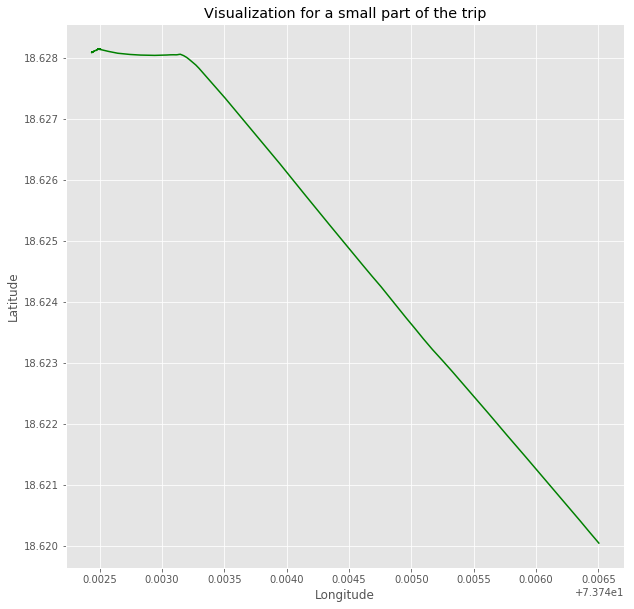

In [266]:
import mplleaflet
plt.figure(figsize=(10,10))
plt.style.use("ggplot")
plt.title("Visualization for a small part of the trip")
plt.plot(df_trip["lon"], df_trip["lat"],"g")
#mplleaflet.show()
#plt.plot(df_trip["lon"], df_trip["lat"], "rs")

plt.ticklabel_format(axis = "both" , style='plain')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
#mplleaflet.show()

In [261]:
# Useful data for our objective
df_trip = df_trip[["index","lat","lon","speed","timestamp"]]
df_trip.head()

,index,lat,lon,speed,timestamp
7000,18974,18.620044,73.746503,75.046744,1537412396256
7001,18975,18.620044,73.746503,75.046744,1537412396557
7002,18976,18.620044,73.746503,75.046744,1537412396844
7003,18977,18.620227,73.746427,75.046744,1537412397000
7004,18978,18.620227,73.746427,75.046744,1537412397155


In [262]:
# Find position based turns (without rotaing axes)
def detect_turn(df_trip):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon"])
    
    df_start = df_trip[0:1]
    lat1 = df_trip["lat"].iloc[0]
    lon1 = df_trip["lon"].iloc[0]
    change = False
    
    for i in range(len(df_trip)):
        
        lat2 = df_trip["lat"].iloc[i]
        lon2 = df_trip["lon"].iloc[i]
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        if(delta_lat != 0) or (delta_lon != 0):
            # Change in lat or long detected
            if change == False:
                # Possible start of a turn
                change = True
                m1 = delta_lat * delta_lon
                df_start = df_trip[i:i+1]
                
                lat1 = lat2
                lon1 = lon2
                
            else:
                # Possible end of turn
                df_end = df_trip[i:i+1]
                m2 = delta_lat * delta_lon
                
                if m1*m2 <= 0:
                    # Turn detected
                    start_index = df_start["index"].iloc[0]
                    end_index = df_end["index"].iloc[0]
                    #start_time = df_start["timestamp"].iloc[0]
                    #print(df_start["timestamp"].iloc[0])
                    start_lat = df_start["lat"].iloc[0]
                    start_lon = df_start["lon"].iloc[0]
                    end_lat = df_end["lat"].iloc[0]
                    end_lon = df_end["lon"].iloc[0]
                    
                    df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon},
                                                ignore_index=True)
                    change = False
                
                else:
                    # Turn not detected, possible start of new turn
                    df_start = df_end
                    m1 = m2
                    lat1 = lat2
                    lon1 = lon2
            
        else:
            lat1 = lat2
            lon1 = lon2
        
    return df_turns

In [263]:
# Turns dataframe
df_turns = detect_turn(df_trip)
df_turns

,start_index,end_index,start_lat,start_lon,end_lat,end_lon
0,19176.0,19180.0,18.628056,73.743148,18.628054,73.743137
1,19189.0,19193.0,18.628047,73.743115,18.628048,73.743092
2,19194.0,19197.0,18.628048,73.743092,18.628047,73.743066
3,19215.0,19219.0,18.628038,73.742942,18.628041,73.742872
4,19268.0,19277.0,18.628144,73.742486,18.628144,73.742508
5,19278.0,19281.0,18.628144,73.742508,18.628142,73.742506
6,19285.0,19290.0,18.628141,73.742504,18.628140,73.742504
7,19291.0,19294.0,18.628140,73.742504,18.628139,73.742504
8,19295.0,19303.0,18.628139,73.742504,18.628136,73.742505
9,19325.0,19332.0,18.628140,73.742487,18.628137,73.742487


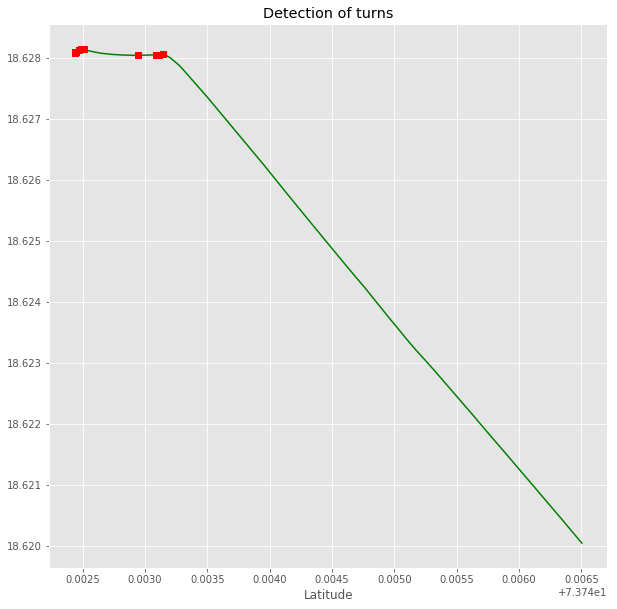

In [264]:
plt.figure(figsize=(10,10))
plt.title("Detection of turns")
plt.plot(df_trip["lon"],df_trip["lat"],"green")
plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
plt.xlabel("Longitude")
plt.xlabel("Latitude")
plt.show()

* **Red squares indicate turning points**

Lets plot some more parts of dataframe to see if the algorithm performs properly

In [221]:
# Function to plot trip with turns
def plot_turns(df_trip, df_turns, height, width):
    plt.figure(figsize=(height,width))
    plt.title("Detection of turns")
    plt.plot(df_trip["lon"],df_trip["lat"],"green")
    plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
    plt.xlabel("Longitudes")
    plt.xlabel("Latitudes")
    plt.show()   

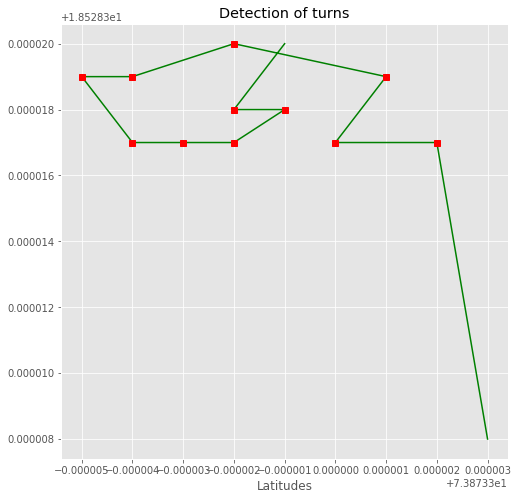

In [222]:
df_trip2 = df[0:100]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 8, 8)

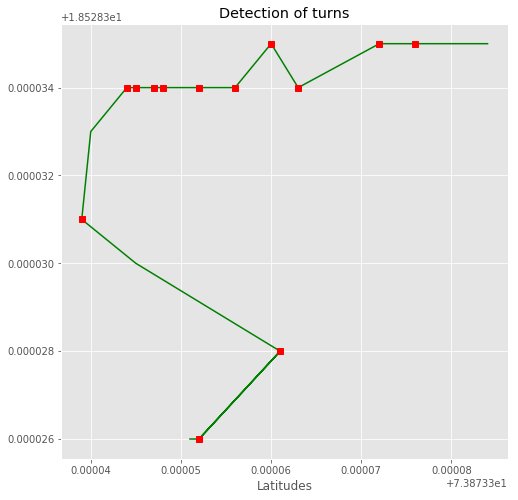

In [223]:
df_trip2 = df[400:500]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns,8, 8)

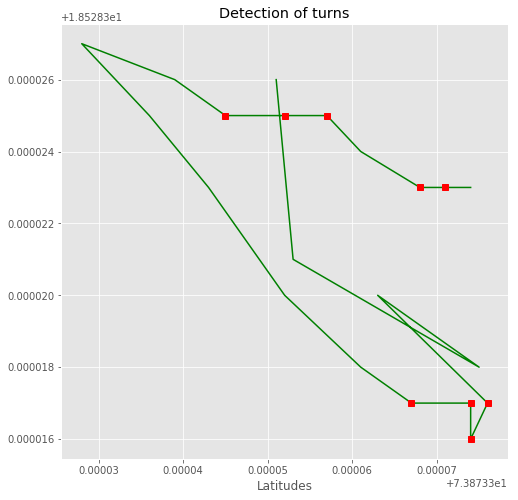

In [224]:
df_trip2 = df[300:400]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 8, 8)

* **As we can see acute turns are not detected. We have to rotate axes by 45 degrees to fix that (page 27 of the research paper)**

## 2. Detect turns with rotating axes

In [225]:
# Find position based turns (with rotaing axes)
def detect_turn_rotated(df_trip):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon"])
    
    df_start = df_trip[0:1]
    lat1 = df_trip["lat"].iloc[0]
    lon1 = df_trip["lon"].iloc[0]
    change = False
    
    for i in range(len(df_trip)):
        
        lat2 = df_trip["lat"].iloc[i]
        lon2 = df_trip["lon"].iloc[i]
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        if(delta_lat != 0) or (delta_lon != 0):
            # Change in lat or long detected
            if change == False:
                # Possible start of a turn
                change = True
                delta_lon2 = (0.707*delta_lon) - (0.707*delta_lat)
                delta_lat2 = (0.707*delta_lon) + (0.707*delta_lat)
                m1 = delta_lat2 * delta_lon2
                df_start = df_trip[i:i+1]
                lat1 = lat2
                lon1 = lon2
                
            else:
                # Possible end of turn
                df_end = df_trip[i:i+1]
                delta_lon2 = (0.707*delta_lon) - (0.707*delta_lat)
                delta_lat2 = (0.707*delta_lon) + (0.707*delta_lat)
                m2 = delta_lat2 * delta_lon2
                
                if m1*m2 <= 0:
                    # Turn detected
                    start_index = df_start["index"].iloc[0]
                    end_index = df_end["index"].iloc[0]
                    #start_time = df_start["timestamp"].iloc[0]
                    #print(df_start["timestamp"].iloc[0])
                    start_lat = df_start["lat"].iloc[0]
                    start_lon = df_start["lon"].iloc[0]
                    end_lat = df_end["lat"].iloc[0]
                    end_lon = df_end["lon"].iloc[0]
                    
                    df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon},
                                                ignore_index=True)
                    change = False
                
                else:
                    # Turn not detected, possible start of new turn
                    df_start = df_end
                    m1 = m2
                    lat1 = lat2
                    lon1 = lon2
            
        else:
            lat1 = lat2
            lon1 = lon2
        
    return df_turns

* **Lets compare the new algorithm with the old one.**
* **Note : results of both the algorithms are to be combined to get the final result.**

Without rotation of axes


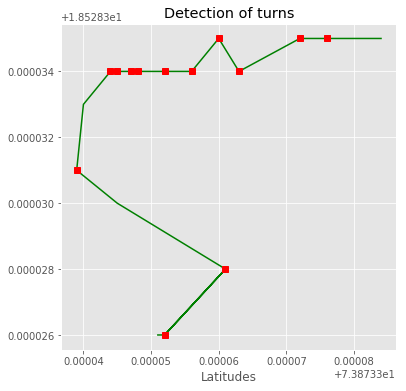

With rotation of axes


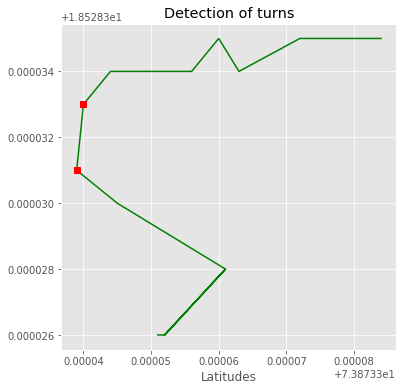

In [226]:
print("Without rotation of axes")
df_trip2 = df[400:500]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 6, 6)

print("With rotation of axes")
df_trip2 = df[400:500]
df_turns = detect_turn_rotated(df_trip2)
plot_turns(df_trip2, df_turns, 6, 6)

Without rotation of axes


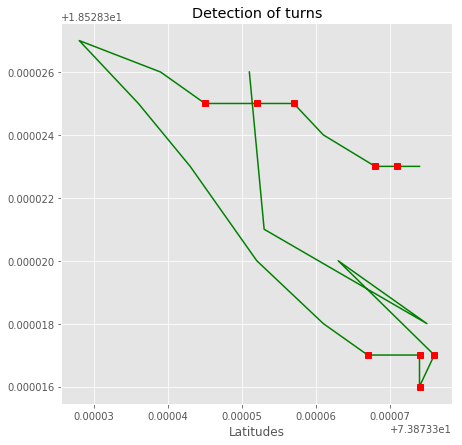

With rotation of axes


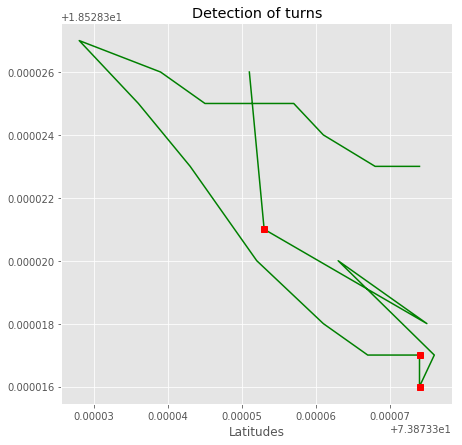

In [227]:
print("Without rotation of axes")
df_trip2 = df[300:400]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 7, 7)

print("With rotation of axes")
df_trip2 = df[300:400]
df_turns = detect_turn_rotated(df_trip2)
plot_turns(df_trip2, df_turns, 7, 7)

Without rotation of axes


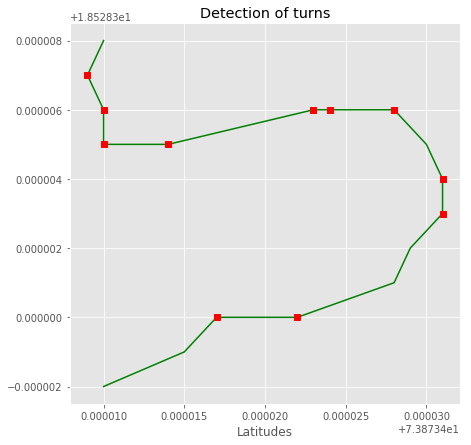

With rotation of axes


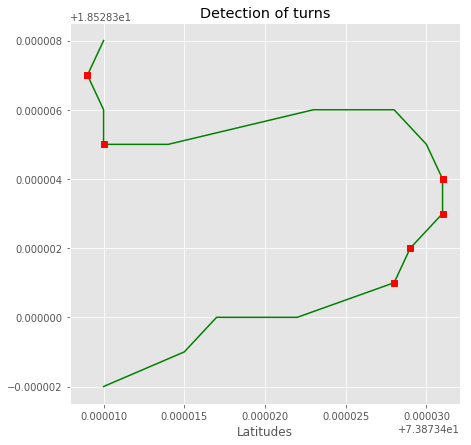

In [228]:
print("Without rotation of axes")
df_trip2 = df[700:800]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 7, 7)

print("With rotation of axes")
df_trip2 = df[700:800]
df_turns = detect_turn_rotated(df_trip2)
plot_turns(df_trip2, df_turns, 7, 7)

* **Combination of both algorithms will give a better result**
* **Very acute turns (less than 20 degrees) are still not being detected** 

## 3. Combining results

In [229]:
# df_turns1 contain result without rotating axes
# df_turns2 contain results with rotating axes
def merge_turns(df_turns1, df_turns2):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon"])
    
    for i in range(len(df_turns1)):
        
        start_index = df_turns1["start_index"].iloc[i]
        end_index = df_turns1["end_index"].iloc[i]
        start_lat = df_turns1["start_lat"].iloc[i]
        start_lon = df_turns1["start_lon"].iloc[i]
        end_lat = df_turns1["end_lat"].iloc[i]
        end_lon = df_turns1["end_lon"].iloc[i]
        df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon},
                                                ignore_index=True)
        
    for i in range(len(df_turns2)):
        
        start_index = df_turns2["start_index"].iloc[i]
        end_index = df_turns2["end_index"].iloc[i]
        start_lat = df_turns2["start_lat"].iloc[i]
        start_lon = df_turns2["start_lon"].iloc[i]
        end_lat = df_turns2["end_lat"].iloc[i]
        end_lon = df_turns2["end_lon"].iloc[i]
        df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon},
                                                ignore_index=True)
    
    df_turns = df_turns.sort_values(by="start_index", ascending = True)
    return df_turns

Without rotating axes


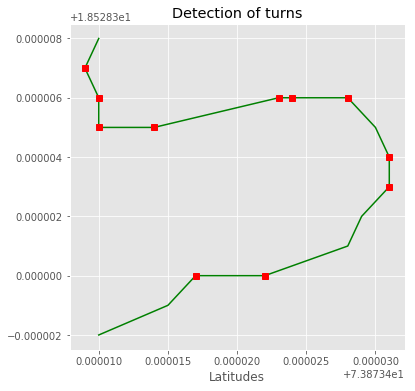

With rotating axes


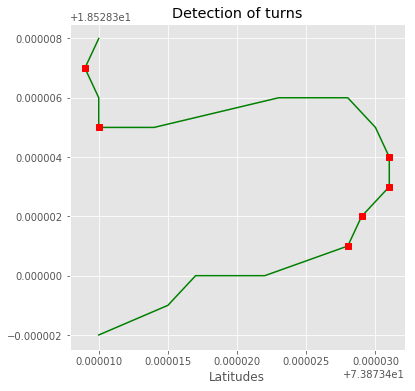

Merged result


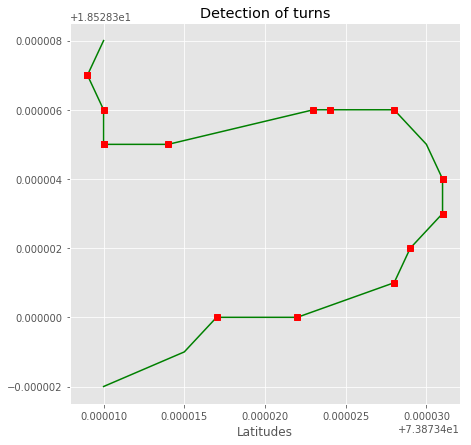

In [230]:
print("Without rotating axes")
df_trip2 = df[700:800]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 6, 6)

print("With rotating axes")
df_trip2 = df[700:800]
df_turns2 = detect_turn_rotated(df_trip2)
plot_turns(df_trip2, df_turns2, 6 , 6)

print("Merged result")
df_merged = merge_turns(df_turns, df_turns2)
plot_turns(df_trip2, df_merged, 7, 7)

Without rotating axes


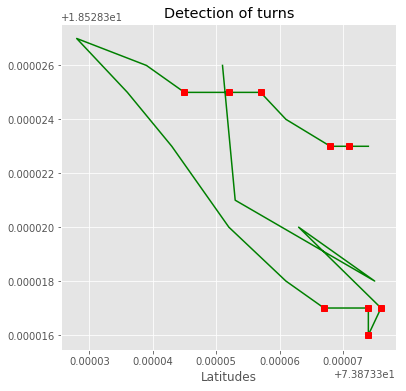

With rotating axes


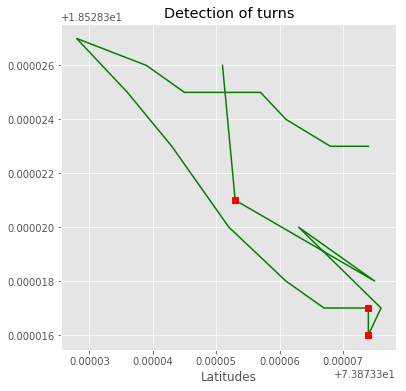

Merged result


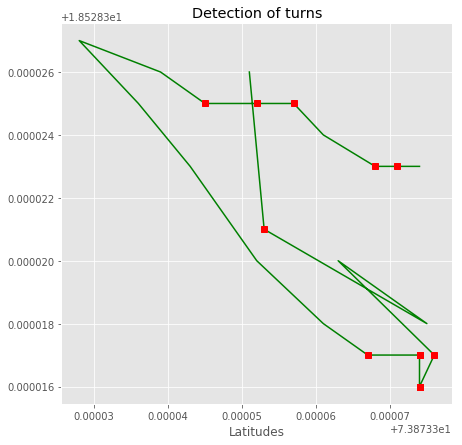

In [265]:
print("Without rotating axes")
df_trip2 = df[300:400]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns, 6, 6)

print("With rotating axes")
df_turns2 = detect_turn_rotated(df_trip2)
plot_turns(df_trip2, df_turns2, 6 , 6)

print("Merged result")
df_merged = merge_turns(df_turns, df_turns2)
plot_turns(df_trip2, df_merged, 7, 7)

### Objectives for 26/01:

* Remove duplicates
* Find speeds at turning points
* Find average speed of the turn

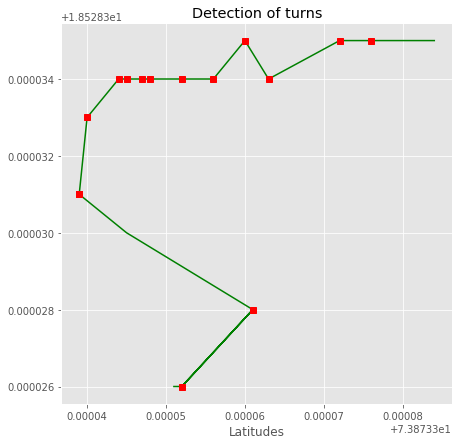

In [232]:
df_trip2 = df[400:500]
df_turns = detect_turn(df_trip2)
df_turns2 = detect_turn_rotated(df_trip2)
df_merged = merge_turns(df_turns, df_turns2)
plot_turns(df_trip2, df_merged, 7, 7)


* If we observe the turns dataset we can see that there are some duplicated values or some values who are very near. 
 - For example row no 2 and 13 are same
 - Row no 4 and 5 have only difference of 4 readings.
* Since we have 6 readings for each second, these "different" turns are essentially the same turn.

In [233]:
def find_distance(lat1, long1, lat2, long2):
    
    DOF_lat = lat1 - lat2
    DOF_long = long1 - long2
    
    dist_lat = DOF_lat * 111139
    dist_long = DOF_long * 111139
    
    dist = np.sqrt((dist_lat*dist_lat) + (dist_long*dist_long))
    
    return dist

In [234]:
# A function to find distance between turns:

def turns_dist(df_merged):
    
    df_turns_dist = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon", "dist_diff"])
    
    df_turns_dist = df_turns_dist.append({"start_index":df_merged["start_index"].iloc[0],
                                         "end_index":df_merged["end_index"].iloc[0],
                                         "start_lat":df_merged["start_lat"].iloc[0],"start_lon":df_merged["start_lon"].iloc[0],
                                         "end_lat":df_merged["end_lat"].iloc[0], "end_lon":df_merged["end_lon"].iloc[0],
                                         "dist_diff":0},ignore_index=True)
    
    for i in range(len(df_merged)):
        if i == 0:
            pass
        else:
            dist_diff = find_distance(df_merged["start_lat"].iloc[i-1], df_merged["start_lon"].iloc[i-1],df_merged["start_lat"].iloc[i], df_merged["start_lon"].iloc[i])
            df_turns_dist = df_turns_dist.append({"start_index":df_merged["start_index"].iloc[i],
                                         "end_index":df_merged["end_index"].iloc[i],
                                         "start_lat":df_merged["start_lat"].iloc[i],"start_lon":df_merged["start_lon"].iloc[i],
                                         "end_lat":df_merged["end_lat"].iloc[i], "end_lon":df_merged["end_lon"].iloc[i],
                                         "dist_diff":dist_diff},ignore_index=True)
    return df_turns_dist

turns_dist(df_merged)

,start_index,end_index,start_lat,start_lon,end_lat,end_lon,dist_diff
0,7677.0,7679.0,18.528326,73.873352,18.528328,73.873361,0.000000
1,7685.0,7688.0,18.528328,73.873361,18.528329,73.873353,1.024651
2,7706.0,7710.0,18.528331,73.873339,18.528333,73.873340,2.467686
3,7706.0,7710.0,18.528331,73.873339,18.528333,73.873340,0.000000
4,7711.0,7723.0,18.528333,73.873340,18.528334,73.873344,0.248514
5,7723.0,7732.0,18.528334,73.873344,18.528334,73.873345,0.458238
6,7733.0,7736.0,18.528334,73.873345,18.528334,73.873347,0.111139
7,7737.0,7741.0,18.528334,73.873347,18.528334,73.873348,0.222278
8,7742.0,7745.0,18.528334,73.873348,18.528334,73.873352,0.111139
9,7746.0,7749.0,18.528334,73.873352,18.528334,73.873356,0.444556


In [235]:
# Function to remove duplicate or near-duplicate values
# A constant FRAME_THRESHOLD is used for this purpose. 
# It measures the closeness of 2 turns. If the difference is less than FRAMES_THRESHOLD, them they are same turns.
# We need to assume some time in which turns cannot occur back to back, I am assuming turns cannot back to back within 2 seconds.
# For our dataset, the value of FRAMES_THRESHOLD will be 2*6 = 12

def remove_duplicates(df_turns):
    
    df_turns_unique = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon"])
    FRAMES_THRESHOLD = 12
    
    turn1 = df_turns[0:1]
    turn2 = df_turns[1:2]
    
    start_frame1 = turn1["start_index"].iloc[0]
    start_frame2 = turn2["start_index"].iloc[0]
    end_frame1 = turn1["end_index"].iloc[0]
    end_frame2 = turn2["end_index"].iloc[0]
    
    if (np.absolute(start_frame1 - start_frame2) >= FRAMES_THRESHOLD) or (np.absolute(end_frame1 - end_frame2) >= FRAMES_THRESHOLD):
        #Need to finish
        
    

In [273]:
import gmplot as gm
df_trip

,index,lat,lon,speed,timestamp
7000,18974,18.620044,73.746503,75.046744,1537412396256
7001,18975,18.620044,73.746503,75.046744,1537412396557
7002,18976,18.620044,73.746503,75.046744,1537412396844
7003,18977,18.620227,73.746427,75.046744,1537412397000
7004,18978,18.620227,73.746427,75.046744,1537412397155
7005,18979,18.620227,73.746427,75.046744,1537412397440
7006,18980,18.620227,73.746427,75.055078,1537412397771
7007,18981,18.620404,73.746355,75.055078,1537412398000
7008,18982,18.620404,73.746355,75.055078,1537412398032
7009,18983,18.620404,73.746355,75.055078,1537412398380


,index,heading,id,img_front,lat,lon,speed,timestamp
700,7981,NE,DB002,NaN,18.528308,73.87341,0.233352,1537409418000
701,7982,NE,DB002,img_front_DB002_2018_09_20_07_40_18_129000.jpg,18.528308,73.87341,0.233352,1537409418129
702,7983,NE,DB002,img_front_DB002_2018_09_20_07_40_18_418000.jpg,18.528308,73.87341,0.233352,1537409418418
703,7984,NE,DB002,img_front_DB002_2018_09_20_07_40_18_672000.jpg,18.528308,73.87341,0.233352,1537409418672
704,7985,NE,DB002,img_front_DB002_2018_09_20_07_40_18_926000.jpg,18.528308,73.87341,0.233352,1537409418926
